# Disease_Similarity_Benchmark

## Load Data

In [1]:
# imports

import logging, sys, os
from tqdm import tqdm
import numpy as np, pandas as pd
from tqdm.contrib.concurrent import process_map
import pickle

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# variables
data_info_path = os.path.join(
    "..", "data", "DiSignAtlas", "Disease_information_Datasets.csv"
)

do_obl_data_path = os.path.join("..", "data", "DiseaseOntology", "doid.obo")
external_links_data_path = os.path.join(
    "..", "data", "DiSignAtlas", "external_links.pkl"
)

# mesh_tree_terms_path = os.path.join("..", "data", "DiSignAtlas", "mesh_tree_terms.pkl")
# mesh_ids_path = os.path.join("..", "data", "DiSignAtlas", "mesh_tree_terms.pkl")


# functions
def get_processed_ids():
    """Get processed ids
    Returns:
        list: list of processed ids
    """
    data_path = os.path.join("..", "data", "DiSignAtlas", "dsa_diff_download.processed")
    return [f.split("_")[0] for f in os.listdir(data_path)]


# Load the all genes per (human) signature


def get_signatures(dsaid, remove_duplicates=True):
    """
    Calculate signed significance for each gene in the signature.
    Args:
        - dsaid: str

    Returns:
        - gene_ids: list
            List of gene IDs
        - p_values: list
            List of p-values
        - de_values: list
            List of log2 fold changes
    """
    data_path = os.path.join(
        "..",
        "data",
        "DiSignAtlas",
        "dsa_diff_download.processed",
        f"{dsaid}_alldiff.txt",
    )

    if os.path.exists(data_path):
        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["GeneID"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["GeneID"].tolist()
        p_values = df_cleaned["PValue"].tolist()
        adj_p_values = df_cleaned["AdjPValue"].tolist()
        log2fc = df_cleaned["Log2FC"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc
    else:
        data_path = os.path.join(
            "..",
            "data",
            "DiSignAtlas",
            "dsa_diff_download.processed",
            f"{dsaid}_whole_diff_regulation.csv",
        )

        df = pd.read_csv(data_path)
        n_deleted_duplicates = df.duplicated(subset=["GeneID"]).sum()

        # remove duplicate gene ids
        if remove_duplicates:
            df = df.drop_duplicates(subset=["geneid"], keep=False)

        # drop nans if present - ideally pre-processing cleans this
        df_cleaned = df.dropna(subset=["PValue", "AdjPValue", "Log2FC"])

        genes = df_cleaned["geneid"].tolist()
        p_values = df_cleaned["pvalue"].tolist()
        adj_p_values = df_cleaned["adjpvalue"].tolist()
        log2fc = df_cleaned["log2fc"].tolist()

        return dsaid, n_deleted_duplicates, genes, p_values, adj_p_values, log2fc


# get all entrez protein-coding human ids
def get_human_entrez_protein_coding_ids():
    """Get Human Entrez IDs
    Returns:
        list: list of human entrez ids
    """
    data_path = os.path.join("..", "data", "ncbi_gene_info", "gene_info")
    df = pd.read_csv(data_path, sep="\t", usecols=["#tax_id", "GeneID", "type_of_gene"])
    df_human = df[(df["#tax_id"] == 9606) & (df["type_of_gene"] == "protein-coding")]
    logging.info(f"Nº of Human protein coding genes: {len(df_human)}")
    return df_human["GeneID"].to_list()


# load data

processed_ids = get_processed_ids()
logging.info(f"Nº of processed ids: {len(processed_ids)}")

df_data_info = pd.read_csv(data_info_path)

df_data_info_processed = df_data_info.copy()

df_data_info_processed = df_data_info_processed[
    df_data_info_processed["dsaid"].isin(processed_ids)
]

logging.info(f"Nº of processed ids in df_data_info: {len(df_data_info_processed)}")

df_data_info_processed_filtered = df_data_info_processed[
    (df_data_info_processed["organism"] == "Homo sapiens")
    & (
        (df_data_info_processed["library_strategy"] == "Microarray")
        | (df_data_info_processed["library_strategy"] == "RNA-Seq")
    )
]
logging.info(
    f"Nº of Filtered by library (filter out single cell): {df_data_info_processed_filtered.shape}"
)

2024-06-03 15:19:31,980 - INFO - Nº of processed ids: 7191
2024-06-03 15:19:32,005 - INFO - Nº of processed ids in df_data_info: 7191
2024-06-03 15:19:32,007 - INFO - Nº of Filtered by library (filter out single cell): (7001, 12)


In [2]:
# logging.info(f"Loading file {mesh_tree_terms_path}")
# with open(mesh_tree_terms_path, "rb") as f:
#     data = pickle.load(f)
#     mesh_tree_terms = data.get("mesh_tree_terms")
#     mesh_dsaids = data.get("dsaids")
#     mesh_ids = data.get("mesh_ids")
#     dsaids_2_mesh_tree_terms = {k: v for k, v in zip(mesh_dsaids, mesh_tree_terms)}
#     dsaids_2_mesh_ids = {k: v for k, v in zip(mesh_dsaids, mesh_ids)}

# dsaids_with_mesh = [k for k, v in dsaids_2_mesh_tree_terms.items() if len(v) > 0]
# logging.info(f"Nº of dsaids with mesh {len(dsaids_with_mesh)}")

In [3]:
import obonet
import networkx as nx
from pyvis.network import Network
from IPython.display import IFrame

# load Disease Ontology network
do_graph = obonet.read_obo(do_obl_data_path)

# Convert to a NetworkX DIRECTED graph
do_G = nx.DiGraph(do_graph)

# map nodes to labels
do_2_label = {}
# Iterate through the nodes in the graph
for node, data in do_G.nodes(data=True):
    # Get the primary ID and name
    primary_id = node
    name = data.get("name", "No name")

    # Add primary ID to the mapping
    do_2_label[primary_id] = name

    # If there are alternative IDs, add them to the mapping as well
    alt_ids = data.get("alt_id", [])
    for alt_id in alt_ids:
        do_2_label[alt_id] = name

# load external links
with open(external_links_data_path, "rb") as f:
    external_links = pickle.load(f)

# get DOID for each dsa
dsaids_2_doids = {}
for dsaid, external_link in zip(
    external_links["dsaids"], external_links["external_links"]
):
    do_ids = [
        link.replace("DO:", "DOID:") for link in external_link if link.startswith("DO")
    ]
    if len(do_ids) > 0:
        dsaids_2_doids[dsaid] = do_ids

dsaids_with_doid = list(dsaids_2_doids.keys())

In [4]:
# get all entrez protein-coding human ids
human_entrez_protein_coding_ids = get_human_entrez_protein_coding_ids()

2024-06-03 15:21:43,099 - INFO - Nº of Human protein coding genes: 20607


In [5]:
thr_counts = 5
disease_2_counts = dict(df_data_info_processed_filtered["disease"].value_counts())

diseases_high_counts = [k for k, v in disease_2_counts.items() if v >= thr_counts]

logging.info(
    f"Nº of Diseases for Benchmark {len(diseases_high_counts)} / {len(disease_2_counts)}"
)

2024-06-03 15:21:43,201 - INFO - Nº of Diseases for Benchmark 276 / 1428


In [6]:
all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

disease_2_dsaids = dict()
for k, v in tqdm(zip(all_diseases, all_dsaids)):
    if k not in disease_2_dsaids.keys():
        disease_2_dsaids[k] = list()
    disease_2_dsaids[k].append(v)

7001it [00:00, 2533372.64it/s]


In [7]:
import pickle

path_pkl = os.path.join("..", "data", "DiSignAtlas", "signatures.pkl")

human_dsaids_processed = df_data_info_processed_filtered["dsaid"].to_list()
human_library_processed = df_data_info_processed_filtered["library_strategy"].to_list()

if not os.path.exists(path_pkl):

    signatures = process_map(
        get_signatures,
        human_dsaids_processed,
        max_workers=8,
        chunksize=10,
    )
    pickle.dump(signatures, open(path_pkl, "wb"))
    logging.info(f"Signatures saved {path_pkl}")

else:
    logging.info(f"Loading signatures from file {path_pkl}")
    signatures = pickle.load(open(path_pkl, "rb"))

2024-06-03 15:21:43,219 - INFO - Loading signatures from file ../data/DiSignAtlas/signatures.pkl


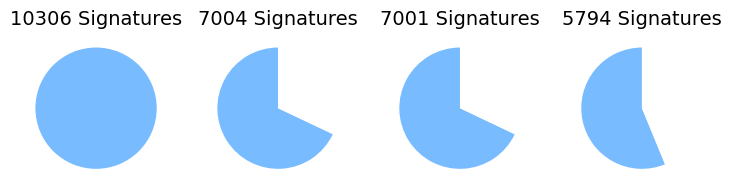

In [8]:
import matplotlib.pyplot as plt

# Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
n_step_0 = df_data_info.shape[0]
n_step_1 = df_data_info[
    (df_data_info["organism"] == "Homo sapiens")
    & (
        (df_data_info["library_strategy"] == "RNA-Seq")
        | (df_data_info["library_strategy"] == "Microarray")
    )
].shape[0]
n_step_2 = df_data_info_processed_filtered.shape[0]
n_step_3 = len(
    set(dsaids_with_doid) & set(df_data_info_processed_filtered["dsaid"].to_list())
)

# Define labels and sizes for the pie charts
sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
sizes_step_2 = [n_step_2, n_step_0 - n_step_2]
sizes_step_3 = [n_step_3, n_step_0 - n_step_3]

# Define colors for the pie charts
colors = ["#78bcffff", "white"]

# Generate the pie charts without labels or percentages, only colors and titles
fig, ax = plt.subplots(1, 4, figsize=(9, 3))

ax[0].pie(sizes_step_0, colors=colors, startangle=90)
ax[0].set_title(f"{n_step_0} Signatures", fontsize=14)
ax[0].set(aspect="equal")
ax[0].set_axis_off()  # Remove borders and ticks

ax[1].pie(sizes_step_1, colors=colors, startangle=90)
ax[1].set_title(f"{n_step_1} Signatures", fontsize=14)
ax[1].set(aspect="equal")
ax[1].set_axis_off()  # Remove borders and ticks

ax[2].pie(sizes_step_2, colors=colors, startangle=90)
ax[2].set_title(f"{n_step_2} Signatures", fontsize=14)
ax[2].set(aspect="equal")
ax[2].set_axis_off()  # Remove borders and ticks

ax[3].pie(sizes_step_3, colors=colors, startangle=90)
ax[3].set_title(f"{n_step_3} Signatures", fontsize=14)
ax[3].set(aspect="equal")
ax[3].set_axis_off()  # Remove borders and ticks


plt.savefig(
    os.path.join("..", "results", "figures", "DiSignAtlas", "mesh.pre_process.png"),
    bbox_inches="tight",
    dpi=300,
)

In [9]:
logging.info(
    f"Nº of non-redundant diseases initially: {df_data_info['disease'].nunique()}"
)
logging.info(
    f"Nº of non-redundant diseases after pre-processing: {df_data_info_processed_filtered['disease'].nunique()}"
)

2024-06-03 15:22:34,778 - INFO - Nº of non-redundant diseases initially: 1836
2024-06-03 15:22:34,784 - INFO - Nº of non-redundant diseases after pre-processing: 1428


In [10]:
interesting_dsaids = []
n_std = list()
vector_len = list()
for i, s in enumerate(tqdm(signatures)):
    if np.any(np.array(s[5]) > 500) or np.any(np.array(s[5]) < -500):
        interesting_dsaids.append((i, s[0], max(s[5]), min(s[5])))

    # compute std
    std = np.std(signatures[i][5])
    mean = np.mean(signatures[i][5])

    n = len(
        [
            value
            for value in signatures[i][5]
            if (value > mean + 6 * std) or (value < mean - 6 * std)
        ]
    )

    vector_len.append(len(signatures[i][5]))
    n_std.append(n)

logging.info(f"Nº of dsaids w/ extreme log2fc: {len(interesting_dsaids)}")
logging.info(f"Signatures: {interesting_dsaids}")

100%|██████████| 7001/7001 [00:34<00:00, 203.08it/s]
2024-06-03 15:23:09,272 - INFO - Nº of dsaids w/ extreme log2fc: 3
2024-06-03 15:23:09,273 - INFO - Signatures: [(3379, 'DSA04659', 283010.779335352, -99319.619817649), (3380, 'DSA04660', 367171.584055279, -408566.783065797), (6416, 'DSA09547', 61042.6740428988, -355887.1218498)]


## Raw Data Exploration

## Define Sparsity & Matrix Dimensions

In [11]:
""" Define Sparsity & Matrix Dimensions

Structure:
    1. Import, Variables and Functions
    2. Get the most common gene ids
    3. Get the dsaids with the most common gene ids
    4. Create the data matrix
"""

# Imports, Variables and Functions
# imports

from collections import Counter

# variabels
sparsity = "HS"
sparsity_perc_sign_thr = {"LS": 0.8878, "HS": 0.25}
sparsity_perc_genes_thr = {"LS": 0.95, "HS": 0.5}
assert sparsity in ["LS", "HS"], "Err Sparsity not recognized"


# functions
def get_diff_dsaids(dsaids, dsaids_human):
    """Get human dataset ids which are different
    Arguments:
        - dsaids_human (list): dsaids of interest
        - dsaids (list): dsaids which are human
    Returns:
        - dsaids _diff_subsample (list): same nº as dsaids of interest,
        but different ones
    """
    import random

    N = len(dsaids)
    dsaids_diff = list(set(dsaids_human) - set(dsaids))
    dsaids_diff_subsample = random.sample(
        dsaids_diff,
        k=N,
    )
    logging.info(f"Sampled {len(dsaids_diff_subsample)} random different dsaids")
    return dsaids_diff_subsample


# 2. Get the most common gene ids
# Map all human protein-coding genes to the signatures
all_gene_ids = [s for signature in signatures for s in set(signature[2])]
counts_all_gene_ids = Counter(all_gene_ids)

counts_all_gene_ids_protein_coding = dict()
for k, v in counts_all_gene_ids.items():
    if k in human_entrez_protein_coding_ids:
        counts_all_gene_ids_protein_coding[k] = v

# Get the sorted counts of protein-coding genes
sorted_counts_all_gene_ids_protein_coding = [
    (k, v)
    for k, v in sorted(
        counts_all_gene_ids_protein_coding.items(),
        key=lambda item: item[1],
        reverse=True,
    )
]

# Get depending on the sparsity the most common gene ids of interest
most_common_gene_ids = [
    k
    for k, v in counts_all_gene_ids_protein_coding.items()
    if v >= int(sparsity_perc_sign_thr.get(sparsity) * len(signatures))
]

logging.info(
    f"{sparsity} Most common gene ids: {len(most_common_gene_ids)} for {sparsity} >= {int(sparsity_perc_sign_thr.get(sparsity) * len(signatures))} / {len(signatures)}"
)

# sort gene ids
most_common_gene_ids = sorted(most_common_gene_ids)


# 3. Get the dsaids with the most common gene ids
# dsaids w/ gene ids
# loop through signatures and get dsaids with an intersection against
# the most common gene ids above or equal to a threshold
dsaids_common_gene_ids = [
    s[0]
    for s in signatures
    if len(set(s[2]).intersection(most_common_gene_ids))
    >= int(len(most_common_gene_ids) * sparsity_perc_genes_thr.get(sparsity))
]

dsaids_filtered_mesh = [d for d in dsaids_common_gene_ids if d in dsaids_with_doid]

logging.info(
    f"Nº of dsaids w/ common gene ids {sparsity}: {len(dsaids_common_gene_ids)}"
)

logging.info(
    f"Nº of dsaids w/ common gene ids & mesh tree terms {len(dsaids_filtered_mesh)}"
)

# 4. Create the data matrix
# create data matrix
data_matrix = np.zeros((len(dsaids_filtered_mesh), len(most_common_gene_ids)))

logging.info(f"Data matrix {sparsity} shape: {data_matrix.shape}")

2024-06-03 15:23:30,011 - INFO - HS Most common gene ids: 18561 for HS >= 1750 / 7001
2024-06-03 15:23:36,489 - INFO - Nº of dsaids w/ common gene ids HS: 6513
2024-06-03 15:23:36,489 - INFO - Nº of dsaids w/ common gene ids & mesh tree terms 5370
2024-06-03 15:23:36,490 - INFO - Data matrix HS shape: (5370, 18561)


In [12]:
import sys


def sizeof_fmt(num, suffix="B"):
    """by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified"""
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, "Yi", suffix)


for name, size in sorted(
    ((name, sys.getsizeof(value)) for name, value in list(locals().items())),
    key=lambda x: -x[1],
)[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                  all_gene_ids: 1008.0 MiB
                   data_matrix: 760.4 MiB
                  df_data_info:  8.9 MiB
        df_data_info_processed:  6.3 MiB
df_data_info_processed_filtered:  6.1 MiB
           counts_all_gene_ids:  2.5 MiB
                    do_2_label: 576.1 KiB
counts_all_gene_ids_protein_coding: 576.1 KiB
                dsaids_2_doids: 288.1 KiB
sorted_counts_all_gene_ids_protein_coding: 169.0 KiB


In [13]:
from scipy import stats

### Compute Matrix

In [14]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# variables
metric_evaluated = "Log2FC"

d_default_value = {
    "PValue": 0.0,
    "AdjPValue": 1.0,
    "Log2FC": 0.0,
    "ReAdjPValue": 0.0,
    "iLINCS.100": 0.0,
    "iLINCS.200": 0.0,
    "iLINCS.all": 0.0,
    "iLINCS.ReAdj": 0.0,
    "Ranking.AdjPValue": 0.0,
    "Ranking.Log2FC": 0.0,
    "Significant.Log2FC": 0.0,
    "Significant.Log2FC.ReAdj": 0.0,
    "Filtered.Log2FC": 0.0,
}

variance_thr = 0.0
de_genes_thr = 30

assert metric_evaluated in [
    "PValue",
    "AdjPValue",
    "Log2FC",
    "ReAdjPValue",
    "iLINCS.100",
    "iLINCS.200",
    "iLINCS.all",
    "iLINCS.ReAdj",
    "Ranking.AdjPValue",
    "Ranking.Log2FC",
    "Significant.Log2FC",
    "Filtered.Log2FC",
    "Significant.Log2FC.ReAdj",
], "Err metric not found"


# functions


def filter_information(reference, labels, values):
    """Filter information by reference
    Args:
        - reference (list): list of reference ids
        - labels (list): list of labe{sparsity}
        - values (list): list of values
    Returns:
        - labels (np.array): np.array of labels
        - values (np.array): np.array of values
    """
    reference = np.array(reference)
    labels = np.array(labels)
    values = np.array(values)
    mask = np.isin(labels, reference)
    return labels[mask], values[mask]


def sort_values(reference, labels, values, default_value=np.nan):
    """Sort values by reference"""

    values = np.array(values)
    d = dict(zip(labels, values))
    return [d.get(k, default_value) for k in reference]


def adjust_p_values(reference, labels, values, method="fdr_bh"):
    values = np.array(values)
    d = dict(zip(labels, values))

    # common labels between reference and labels
    common_labels = list(set(reference).intersection(set(labels)))

    # get values
    values = [d[k] for k in common_labels]

    if method == "fdr_bh":
        # adjust p-values
        adjusted_values = stats.false_discovery_control(values)

    # possible other methods (?)

    return common_labels, adjusted_values


def compute_signed_significance(p_values, log2fcs):
    """
    Calculate signed significance for each gene in the signature.
    Args:
    - dsaid: str

    Returns:
    - signed_significance: list of tupples
    - d_signed_significance: list of tupples
    """
    p_values = np.array(p_values)
    log2fcs = np.array(log2fcs)

    assert len(p_values) == len(log2fcs), "Err p_values and log2fcs not same length"
    signed_significance = list()
    for p_value, logfc in zip(p_values, log2fcs):
        # P Value should neve be 0
        if p_value == 0:
            p_value = min(p_values[p_values != 0])
        # chek if p_value is nan
        if not np.isnan(p_value):
            sign = np.sign(logfc)
            ss = sign * (-np.log10(p_value))
            signed_significance.append(ss)
        if np.isnan(p_value):
            raise ValueError("Log2FC is nan")
    return np.array(signed_significance)


def compute_extreme_signed_significance(signed_significance, genes, k=100):
    """
    Compute Extreme Signed Significance for top & bottom k ss genes, rest
    are assigned value of 0.

    Arguments:
    - signed_significance (np.array): list of signed significance

    - genes (np.array): list of gene ids

    - k: int()
        Top/Bottom k genes.

    Returns:
    - genes: list of gene ids
    - extreme_signed_significance: list of tupples
        List of gene ids and signed significance
    """
    # check if there are nans in the signed significance
    signed_significance_no_nan = signed_significance[~np.isnan(signed_significance)]
    signed_significance_nan = signed_significance[np.isnan(signed_significance)]

    genes_no_nan = genes[~np.isnan(signed_significance)]
    genes_nan = genes[np.isnan(signed_significance)]

    # Sort the signed_significance_no_nan in ascending order and get sorted indices
    sorted_indices = np.argsort(signed_significance_no_nan)

    # Apply sorting to both signed_significance_no_nan and genes_no_nan
    sorted_signed_significance_no_nan = signed_significance_no_nan[sorted_indices]
    sorted_genes_no_nan = genes_no_nan[sorted_indices]

    # Initialize a mask for all values as False (indicating all will be set to 0)
    mask = np.zeros(sorted_signed_significance_no_nan.shape, dtype=bool)

    # if there are 0s in the top or bottom 100 then they will be still 0's
    # after the mask

    if k:
        # Set True for the top 100 (smallest) and bottom 100 (largest) values in ascending order
        mask[:k] = True  # Smallest values
        mask[-k:] = True  # Largest values before NaNs

        # Apply the mask, setting values not in the top or bottom 100 to 0
        sorted_signed_significance_no_nan[~mask] = 0

    # Concatenate with NaN parts
    final_signed_significance = np.concatenate(
        [sorted_signed_significance_no_nan, signed_significance_nan]
    )
    final_genes = np.concatenate([sorted_genes_no_nan, genes_nan])
    return final_genes, final_signed_significance


def compute_ranking_log2fc(values, n, threshold=0.5):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        if values[i] > threshold:
            # from 1 to n
            ranking[i] = 1 + counter

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < -threshold:
            # from -n to -1
            ranking[i] = -n + counter

    return ranking


def compute_ranking_log2fc(values, n, threshold=0.5):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n top values
    for counter, i in enumerate(sorted_indexes[-n:]):
        if values[i] > threshold:
            # from 1 to n
            ranking[i] = 1 + counter

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < -threshold:
            # from -n to -1
            ranking[i] = -n + counter

    return ranking


def compute_ranking_adj_pvalue(values, n, threshold=0.05):
    """Compute ranking
    Arguments:
        - values (numpy): array of values
        - n (int): nº of top values
    Returns:
        - ranking (numpy): array of ranking

    """
    # initialize ranking values
    ranking = np.zeros(len(values))

    # get sorted indexes
    sorted_indexes = np.argsort(values)

    # assign values to n bottom values
    for counter, i in enumerate(sorted_indexes[:n]):
        if values[i] < threshold:
            # from -n to -1
            ranking[i] = n - counter

    return ranking


def get_significant_log2fc(
    log2fc, adj_p_values, thr_log2fc=0, thr_adj_p_values=0.05, normalize=False
):
    """Get significant log2fc
    Arguments:
        - log2fc (list): list of log2fc
        - adj_p_values (list): list of adj_p_values
        - thr_log2fc (float): threshold for log2fc
        - thr_adj_p_values (float): threshold for adj_p_values
    Returns:
        - significant_log2fc (list): list of significant log2fc
    """
    if normalize:
        # to do
        pass
    else:
        significant_log2fc = list()
        for i in range(len(log2fc)):
            if (abs(log2fc[i]) >= thr_log2fc) and (adj_p_values[i] <= thr_adj_p_values):
                significant_log2fc.append(log2fc[i])
            else:
                significant_log2fc.append(np.nan)
        return np.array(significant_log2fc)


def get_filtered_log2fc(log2fc, winsorize_limit=0.001):
    """Get filtered log2fc
    Returns:
        - log2fc (list): list of log2fc
    """
    # imports
    from scipy.stats.mstats import winsorize
    import numpy as np

    # using scikit-learn's MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler

    # Winsorizing data
    log2fc_winsorized = winsorize(np.array(log2fc), limits=winsorize_limit).data

    # Convert masked array to numpy array
    log2fc_winsorized = np.array(log2fc_winsorized.data)
    # Create a MinMaxScaler object with range [-1, 1]
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Normalize the data
    # Reshape data for the scaler
    log2fc_normalized = scaler.fit_transform(log2fc_winsorized.reshape(-1, 1))
    return log2fc_normalized.flatten()


# matrix w/ common gene ids
zero_variance_dsaids_all_genes = list()
zero_variance_dsaids_specific_genes = list()
zero_significant_dsaids = list()
dsaids_matrix = list()
rows_filled = 0
if metric_evaluated.startswith("iLINCS"):
    n_ess = list()

for i, dsaid_specific in enumerate(tqdm(dsaids_filtered_mesh)):
    if (dsaid_specific == "DSA04660") or (dsaid_specific == "DSA09547"):
        continue
    # get index of dsaid
    idx = human_dsaids_processed.index(dsaid_specific)

    # retrieve signature
    signature = signatures[idx]

    # quality check
    assert signatures[idx][0] == dsaid_specific, "Err not matching dsaid"

    # get values
    gene_ids = signature[2]
    p_values = signature[3]
    adj_p_values = signature[4]
    log2fc = signature[5]

    # check variance for all genes
    if (np.var(adj_p_values) == variance_thr) or (np.var(log2fc) == variance_thr):
        zero_variance_dsaids_all_genes.append(dsaid_specific)
        continue

    # sort values
    if metric_evaluated == "AdjPValue":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=adj_p_values,
        )
    elif metric_evaluated == "Log2FC":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=log2fc,
        )

    elif metric_evaluated == "PValue":
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=p_values,
        )

    elif metric_evaluated == "ReAdjPValue":

        common_gene_ids, re_adj_p_values = adjust_p_values(
            reference=most_common_gene_ids, labels=gene_ids, values=p_values
        )

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=p_values,
        )

    elif metric_evaluated.startswith("iLINCS"):
        """Wer are computing the extreme signed significance for
        those genes of interest. Not for all genes. This is a decision
        which is arbitrary. Justification is that we are interested in
        the scope of genes of interest.
        """

        if metric_evaluated == "iLINCS.ReAdj":
            # re-adjust p-values
            common_gene_ids, re_adj_p_values = adjust_p_values(
                reference=most_common_gene_ids, labels=gene_ids, values=p_values
            )

            # order log2fc same order as adj_p_values
            d_log2fc = dict(zip(gene_ids, log2fc))
            ordered_log2fc = [d_log2fc.get(id) for id in common_gene_ids]

            # re-define variables for later
            log2fc = ordered_log2fc
            adj_p_values = re_adj_p_values
            gene_ids = common_gene_ids

        # filter adj_p_values
        filtered_gene_ids, filtered_adj_p_values = filter_information(
            reference=most_common_gene_ids, labels=gene_ids, values=adj_p_values
        )

        # filter log2fc
        filtered_gene_ids, filtered_log2fc = filter_information(
            reference=most_common_gene_ids, labels=gene_ids, values=log2fc
        )

        # compute signed significance
        signed_significance = compute_signed_significance(
            filtered_adj_p_values, filtered_log2fc
        )

        k_ilincs = (
            False
            if metric_evaluated == "iLINCS.all" or metric_evaluated == "iLINCS.ReAdj"
            else int(metric_evaluated.split(".")[1])
        )

        # compute extreme signed significance
        gene_ids_ess, ess = compute_extreme_signed_significance(
            signed_significance=signed_significance,
            genes=filtered_gene_ids,
            k=k_ilincs,
        )

        # sort values
        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids_ess,
            values=ess,
        )

    if metric_evaluated == "Ranking.AdjPValue":

        # compute ranking
        ranking = compute_ranking_adj_pvalue(adj_p_values, n=200, threshold=0.05)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=ranking,
        )

    if metric_evaluated == "Ranking.Log2FC":

        # compute ranking
        ranking = compute_ranking_log2fc(log2fc, n=100, threshold=0.5)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=ranking,
        )

    if metric_evaluated == "Significant.Log2FC":

        # compute ranking
        significant_log2fc = get_significant_log2fc(
            log2fc, adj_p_values, thr_log2fc=0, thr_adj_p_values=0.05, normalize=False
        )

        if np.any(significant_log2fc) < -1:
            break

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=significant_log2fc,
        )

    if metric_evaluated == "Significant.Log2FC.ReAdj":
        common_gene_ids, re_adj_p_values = adjust_p_values(
            reference=most_common_gene_ids, labels=gene_ids, values=p_values
        )

        # order log2fc same order as adj_p_values
        d_log2fc = dict(zip(gene_ids, log2fc))
        ordered_log2fc = [d_log2fc.get(id) for id in common_gene_ids]

        # get significant log2fc
        significant_log2fc = get_significant_log2fc(
            ordered_log2fc,
            re_adj_p_values,
            thr_log2fc=0,
            thr_adj_p_values=0.05,
            normalize=False,
        )

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=common_gene_ids,
            values=significant_log2fc,
        )

    if metric_evaluated == "Filtered.Log2FC":
        # compute filtered log2fc
        filtered_log2fc = get_filtered_log2fc(log2fc, winsorize_limit=0.001)

        sorted_values = sort_values(
            reference=most_common_gene_ids,
            labels=gene_ids,
            values=filtered_log2fc,
        )

    # check variance for specific genes
    # check if there are significant genes here
    if len(np.array(sorted_values)[~np.isnan(sorted_values)]) == 0:
        zero_significant_dsaids.append(dsaid_specific)
        continue

    if np.var(np.array(sorted_values)[~np.isnan(sorted_values)]) == variance_thr:
        zero_variance_dsaids_specific_genes.append(dsaid_specific)

        continue

    # check nº of extreme signed significance genes
    if metric_evaluated.startswith("iLINCS"):
        ess_no_nan = ess[~np.isnan(ess)]
        if np.array(ess_no_nan, dtype="bool").sum() <= de_genes_thr:
            continue

    # fill rows with data
    for j, value in enumerate(sorted_values):
        data_matrix[rows_filled, j] = value

    # if it passes check ! !
    rows_filled += 1
    dsaids_matrix.append(dsaid_specific)


# remove rows not filled
data_matrix = data_matrix[:rows_filled, :]
logging.info(f"Data matrix {sparsity} shape: {data_matrix.shape}")


# report how many dsaids have zero variance
logging.info(
    f"{sparsity} Zero variance dsaids all genes: {len(zero_variance_dsaids_all_genes)}"
)
logging.info(
    f"{sparsity} Zero variance dsaids specific genes: {len(zero_variance_dsaids_specific_genes)}"
)

# check zero variance genes
count = 0
for j in range(data_matrix.shape[1]):
    if np.var(data_matrix[:, j]) == 0:
        count += 1
assert count == 0, "Err zero variance genes"

# check zero variance dsaids
count = 0
for i in range(data_matrix.shape[0]):
    if np.var(data_matrix[i]) == 0:
        count += 1
assert count == 0, "Err zero variance dsaids"

# check de genes in iLINCS processing
for row in range(data_matrix.shape[0]):
    if data_matrix[row, :].astype(bool).sum() <= de_genes_thr:
        raise ValueError(f"{sparsity} Err nº of DE genes <= {de_genes_thr}")

# mask where there are nans
nan_mask = np.isnan(data_matrix)

# assign nans default value
data_matrix[nan_mask] = d_default_value.get(metric_evaluated)

100%|██████████| 5370/5370 [00:42<00:00, 126.82it/s]
2024-06-03 15:24:19,193 - INFO - Data matrix HS shape: (5353, 18561)
2024-06-03 15:24:19,193 - INFO - HS Zero variance dsaids all genes: 16
2024-06-03 15:24:19,193 - INFO - HS Zero variance dsaids specific genes: 0


In [15]:
%store

Stored variables and their in-db values:


In [16]:
df_matrix = df_data_info_processed_filtered[
    df_data_info_processed_filtered["dsaid"].isin(dsaids_matrix)
]

logging.info(f"Nº signatures {df_matrix.shape[0]}")
logging.info(f"Nº unique diseases {df_matrix['disease'].nunique()}")

2024-06-03 15:24:20,409 - INFO - Nº signatures 5353
2024-06-03 15:24:20,409 - INFO - Nº unique diseases 886


In [17]:
metric_evaluated = "iLINCS" if metric_evaluated == "iLINCS.100" else metric_evaluated

### Diagnostic plots

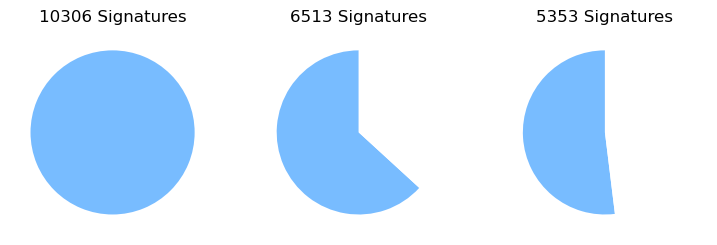

In [18]:
import matplotlib.pyplot as plt

# Assuming values for n_step_0, n_step_1, and n_step_2 for demonstration
n_step_0 = df_data_info.shape[0]
n_step_1 = len(dsaids_common_gene_ids)
n_step_2 = len(dsaids_matrix)

# Define labels and sizes for the pie charts
sizes_step_0 = [n_step_0, 0]  # Initially, nothing is filtered out
sizes_step_1 = [n_step_1, n_step_0 - n_step_1]
sizes_step_2 = [n_step_2, n_step_0 - n_step_2]

# Define colors for the pie charts
colors = ["#78bcffff", "white"]

# Generate the pie charts without labels or percentages, only colors and titles
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].pie(sizes_step_0, colors=colors, startangle=90)
ax[0].set_title(f"{n_step_0} Signatures")
ax[0].set(aspect="equal")
ax[0].set_axis_off()  # Remove borders and ticks

ax[1].pie(sizes_step_1, colors=colors, startangle=90)
ax[1].set_title(f"{n_step_1} Signatures")
ax[1].set(aspect="equal")
ax[1].set_axis_off()  # Remove borders and ticks

ax[2].pie(sizes_step_2, colors=colors, startangle=90)
ax[2].set_title(f"{n_step_2} Signatures")
ax[2].set(aspect="equal")
ax[2].set_axis_off()  # Remove borders and ticks

plt.savefig(
    os.path.join(
        "..", "results", "figures", "DiSignAtlas", f"mesh.data_process.{sparsity}.png"
    ),
    bbox_inches="tight",
    dpi=300,
)

In [19]:
# get diseases of interest
dsaid_2_disease = dict(df_data_info_processed_filtered[["dsaid", "disease"]].values)


count_diseases = Counter([dsaid_2_disease[dsaid] for dsaid in dsaids_filtered_mesh])
diseases_to_check = [k for k, v in count_diseases.items() if v >= 5]
logging.info(f"Nº of most common diseases in df: {len(diseases_to_check)}")

# get disease to dsaids of interest
disease_2_dsaid_filtered = dict()

all_diseases = df_data_info_processed_filtered["disease"].to_list()
all_dsaids = df_data_info_processed_filtered["dsaid"].to_list()

# loop through all diseases
for disease, dsaid in zip(all_diseases, all_dsaids):
    # loop through diseases of interest
    # if disease in diseases_to_check:
    # check if dsaids are in matrix ids
    if dsaid in dsaids_matrix:
        if disease not in disease_2_dsaid_filtered.keys():
            disease_2_dsaid_filtered[disease] = list()
        disease_2_dsaid_filtered[disease].append(dsaid)


most_common_diseases = [k for k, v in disease_2_dsaid_filtered.items() if len(v) >= 5]

logging.info(f"Nº of most common diseases in matrix: {len(most_common_diseases)}")

2024-06-03 15:24:20,577 - INFO - Nº of most common diseases in df: 216
2024-06-03 15:24:20,761 - INFO - Nº of most common diseases in matrix: 216


<Figure size 450x400 with 0 Axes>

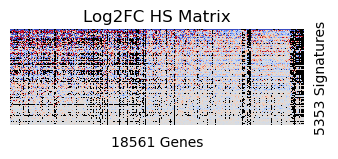

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4.5, 4))


# Set the color palette
cmap = sns.color_palette("coolwarm", as_cmap=True)
if metric_evaluated == "Ranking.AdjPValue":
    cmap = sns.color_palette("Reds", as_cmap=True)


cmap.set_bad(color="black")

if (
    (metric_evaluated == "AdjPValue")
    or (metric_evaluated == "PValue")
    or (metric_evaluated == "ReAdjPValue")
):
    min_val = 0
    max_val = 1
    cluster = True
elif "Log2FC" in metric_evaluated:
    min_val = -1.5
    max_val = 1.5
    cluster = True
elif metric_evaluated.startswith("iLINCS"):
    min_val = -10
    max_val = 10
    cluster = False
elif metric_evaluated == "Ranking.AdjPValue":
    min_val = 0
    max_val = 200
    cluster = False

elif metric_evaluated == "Ranking.Log2FC":
    min_val = -200
    max_val = 200
    cluster = False
elif metric_evaluated == "Significant.Log2FC":
    min_val = -100
    max_val = 100
    cluster = False


# subset data matrix

rows = np.random.choice(data_matrix.shape[0], 3000, replace=False)
cols = np.random.choice(data_matrix.shape[1], 3000, replace=False)

# Plot the clustermap without dendrograms and color bar
cg = sns.clustermap(
    data_matrix[rows][:, cols],
    cmap=cmap,
    mask=nan_mask[rows][:, cols],
    row_cluster=True,
    col_cluster=True,
    # dendrogram_ratio=(0.1, 0.1),  # Very small dendrogram size
    figsize=(4.5, 2),  # Control the size of the clustermap here
    cbar_pos=None,
    vmin=min_val,
    vmax=max_val,
)  # No color bar

# Suppress dendrograms
cg.ax_row_dendrogram.set_visible(False)  # suppress row dendrogram
cg.ax_col_dendrogram.set_visible(False)  # suppress column dendrogram

# Remove x and y labels
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])

# Set axis labels
cg.ax_heatmap.set_xlabel(f"{len(most_common_gene_ids)} Genes")  # Set x-axis label
cg.ax_heatmap.set_ylabel(f"{len(dsaids_matrix)} Signatures")  # Set y-axis label

cg.ax_heatmap.tick_params(axis="both", which="both", length=0)  # Remove tick lines

plt.title(f"{metric_evaluated} {sparsity} Matrix")

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.cluster_map.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

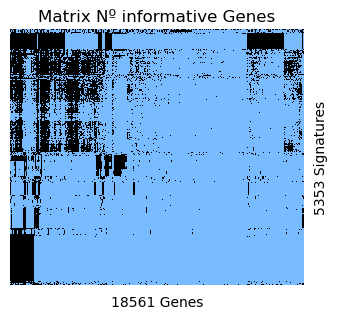

In [21]:
from matplotlib.colors import ListedColormap

# Define a custom color map: 1s in blue, 0s in black
cmap = sns.color_palette("light:b", as_cmap=True)
cmap.set_bad(color="black")


_data_matrix = data_matrix.copy()
_data_matrix = np.ones_like(_data_matrix)
_data_matrix[nan_mask] = 0

# Define a custom color map: 1s in blue, 0s in black, NaNs in gray
cmap = ListedColormap(["black", "#78bcff"])
cmap.set_bad("gray", 1.0)  # Handle NaN values, setting them to gray

# Randomly select rows and columns
rows = np.random.choice(data_matrix.shape[0], 3000, replace=False)
cols = np.random.choice(data_matrix.shape[1], 3000, replace=False)


# Plot the cluster map without applying nan_mask as mask parameter since we've handled NaNs
cg = sns.clustermap(
    _data_matrix[rows][:, cols],
    cmap=cmap,
    figsize=(4.5, 4),
    cbar_pos=None,
    col_cluster=True,
    row_cluster=True,
    vmin=0,  # Minimum value for color mapping
    vmax=1,  # Maximum value for color mapping
)


# Suppress dendrograms
cg.ax_row_dendrogram.set_visible(False)  # suppress row dendrogram
cg.ax_col_dendrogram.set_visible(False)  # suppress column dendrogram

# Remove x and y labels
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])

# Set axis labels
cg.ax_heatmap.set_xlabel(f"{len(most_common_gene_ids)} Genes")  # Set x-axis label
cg.ax_heatmap.set_ylabel(f"{len(dsaids_matrix)} Signatures")  # Set y-axis label

cg.ax_heatmap.tick_params(axis="both", which="both", length=0)  # Remove tick lines
# plt.title("%s Matrix" % {"LS": "Low Sparsity", "HS": "High Sparsity"}[sparsity])
plt.title(f"Matrix Nº informative Genes")

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.cluster_map.nans.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

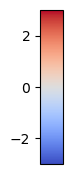

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# Set min and max values based on 'metric_evaluated'
if (
    (metric_evaluated == "AdjPValue")
    or (metric_evaluated == "PValue")
    or (metric_evaluated == "ReAdjPValue")
):
    min_val = 0
    max_val = 1
elif "Log2FC" in metric_evaluated:
    min_val = -3
    max_val = 3
elif metric_evaluated.startswith("iLINCS"):
    min_val = -10
    max_val = 10
elif metric_evaluated == "Ranking.AdjPValue":
    min_val = 0
    max_val = 200
elif metric_evaluated == "Ranking.Log2FC":
    min_val = -200
    max_val = 200
elif metric_evaluated == "Significant.Log2FC":
    min_val = -100
    max_val = 100

# Set the color palette
cmap = sns.color_palette("coolwarm", as_cmap=True)
if metric_evaluated == "Ranking.AdjPValue":
    cmap = sns.color_palette("Reds", as_cmap=True)


# Create a figure for the color bar
fig, ax = plt.subplots(figsize=(0.3, 2))

# Create a scalar mappable for the color bar
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can safely ignore this line as it's just to avoid warnings

# Create the color bar
cbar = plt.colorbar(sm, cax=ax)

# Set the label of the color bar based on the metric evaluated
# cbar.set_label(metric_evaluated)

# Move color bar tick labels and lines to the left
cbar.ax.yaxis.set_ticks_position("left")  # This moves tick lines to the left
cbar.ax.yaxis.set_label_position(
    "left"
)  # This ensures the label is aligned with the ticks
cbar.ax.yaxis.set_tick_params(
    labelleft=True, labelright=False
)  # Adjusts labels to the left


# Save the color bar as a separate figure
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.cbar_{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

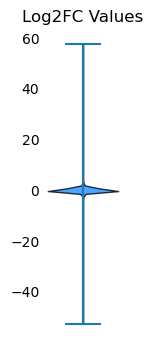

In [23]:
# plot value distribution

values = [np.min(data_matrix)]
values.append(np.max(data_matrix))
values.extend(np.random.choice(data_matrix.flatten(), 5000, replace=False))


plt.figure(figsize=(1, 4))
violin_parts = plt.violinplot(
    values,
    showmeans=False,
    showmedians=False,
    showextrema=True,  # Hides the min, max, median, and mean indicators
)


# Customize the appearance of the violin plot
violin_parts["bodies"][0].set_facecolor("#1E90FF")
violin_parts["bodies"][0].set_edgecolor("black")
violin_parts["bodies"][0].set_alpha(0.8)

# remove y ticks
plt.xticks([])
plt.tick_params(
    axis="y", which="both", length=0
)  # Set the tick length to 0 for the y-axis

# Remove the spines of the top, bottom, and left
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Move y-axis ticks to the right
# plt.gca().yaxis.tick_right()
title = f"{metric_evaluated} Values"
if metric_evaluated == "Log2FC":
    title = f"{metric_evaluated} Values"

if len(title) > 22:
    plt.title(title[:16] + "...", ha="center")
else:
    plt.title(title, ha="center")


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.value_distribution.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

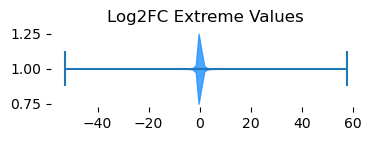

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assume 'data_matrix' and 'metric_evaluated' are defined
# Compute percentiles to focus on extreme values
values = data_matrix.flatten()

# Create the violin plot horizontally
plt.figure(figsize=(4, 1))  # Adjusted aspect ratio for horizontal plot
violin_parts = plt.violinplot(
    values,
    vert=False,  # Make the plot horizontal
    showmeans=False,
    showmedians=False,
    showextrema=True,
)

# Customize the appearance
violin_parts["bodies"][0].set_facecolor("#1E90FF")
violin_parts["bodies"][0].set_edgecolor("#1E90FF")
violin_parts["bodies"][0].set_alpha(0.8)

# Remove x ticks and adjust y ticks to the right
# plt.yticks([])
# plt.tick_params(axis="x", which="both", length=0)

# Remove the spines
for spine in ["top", "bottom", "left", "right"]:
    plt.gca().spines[spine].set_visible(False)

# Adjust title based on length
title = f"{metric_evaluated} Extreme Values"
if len(title) > 22:
    plt.title(title[:16] + "...", ha="center")
else:
    plt.title(title, ha="center")

# Specify file path and save
file_path = os.path.join(
    "..",
    "results",
    "figures",
    "DiSignAtlas",
    f"mesh.violinplot.extreme.{metric_evaluated}.png",
)
plt.savefig(file_path, dpi=300, bbox_inches="tight")

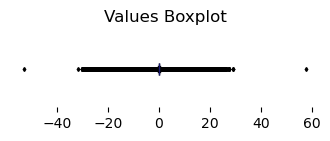

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assume 'data_matrix' and 'metric_evaluated' are defined
# Flatten the data matrix to prepare for plotting
values = data_matrix.flatten()

# Create the boxplot horizontally
plt.figure(figsize=(4, 1))  # Adjusted aspect ratio for horizontal plot
box_parts = plt.boxplot(
    values,
    vert=False,  # Make the plot horizontal
    showmeans=False,  # Decide if the mean should be shown
    showcaps=True,  # Shows the caps on the whiskers
    patch_artist=True,  # Necessary for customizing colors
    flierprops={
        "marker": "d",
        "markerfacecolor": "black",
        "markersize": 2,
        "markeredgecolor": "black",
    },
)

# Customize the appearance
box_parts["boxes"][0].set_facecolor("#1E90FF")
box_parts["boxes"][0].set_edgecolor("black")
box_parts["medians"][0].set_color("midnightblue")  # Customize the median line color

# Remove x ticks and adjust y ticks
plt.yticks([])  # Remove x ticks if unnecessary
plt.tick_params(axis="y", which="both", length=0)  # Adjust tick parameters

# Remove the spines
for spine in ["top", "bottom", "left", "right"]:
    plt.gca().spines[spine].set_visible(False)

# Adjust title based on length
title = "Values Boxplot"
if len(title) > 22:
    plt.title(title[:16] + "...", ha="center")
else:
    plt.title(title, ha="center")

# Uncomment the following lines if you wish to save the plot
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.boxplot.value_distribution.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [26]:
np.max(data_matrix.flatten())

57.5877830197835

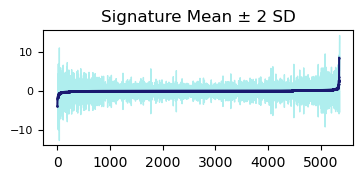

In [27]:
import numpy as np
import matplotlib.pyplot as plt

log_scale = False
n_std = 2
# Calculate means and standard deviations
means = data_matrix.mean(axis=1)
std_devs = n_std * data_matrix.std(axis=1)

# Sort columns by mean
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
sorted_std_devs = std_devs[sorted_indices]

# Create a plot
plt.figure(figsize=(4, 1.5))
plt.plot(
    range(data_matrix.shape[0]),
    sorted_means,
    "o-",
    label="Mean",
    color="midnightblue",
    markersize=0.7,
)
plt.fill_between(
    range(data_matrix.shape[0]),
    sorted_means - sorted_std_devs,
    sorted_means + sorted_std_devs,
    color="paleturquoise",
    alpha=1,
    label=f"Mean ± {n_std} SD",
)

if log_scale:
    plt.yscale("symlog")
    plt.title(f"Signature Mean ± {n_std} SD (log scale)")
else:
    plt.title(f"Signature Mean ± {n_std} SD")
# plt.xlabel("Columns (sorted)")
plt.yticks(fontsize=8)
# plt.xlim(0 - 100, data_matrix.shape[0] + 100)
plt.grid(False)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"value_signature.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

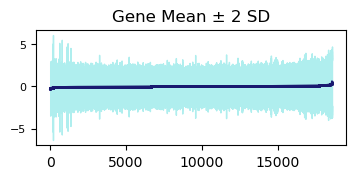

In [28]:
import numpy as np
import matplotlib.pyplot as plt

log_scale = False
n_std = 2
# Calculate means and standard deviations
means = data_matrix.mean(axis=0)
std_devs = n_std * data_matrix.std(axis=0)

# Sort columns by mean
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
sorted_std_devs = std_devs[sorted_indices]

# Create a plot
plt.figure(figsize=(4, 1.5))
plt.plot(
    range(data_matrix.shape[1]),
    sorted_means,
    "o-",
    label="Mean",
    color="midnightblue",
    markersize=0.7,
)
plt.fill_between(
    range(data_matrix.shape[1]),
    sorted_means - sorted_std_devs,
    sorted_means + sorted_std_devs,
    color="paleturquoise",
    alpha=1,
    label=f"Mean ± {n_std} SD",
)
if log_scale:
    plt.yscale("symlog")
    plt.title(f"Gene Mean ± {n_std} SD (log scale)")
else:
    plt.title(f"Gene Mean ± {n_std} SD")
# plt.xlabel("Columns (sorted)")
plt.yticks(fontsize=8)
# plt.ylabel("Mean Values")
# plt.legend()
plt.grid(False)
# plt.xlim(0 - 100, data_matrix.shape[1] + 100)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"value_gene.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

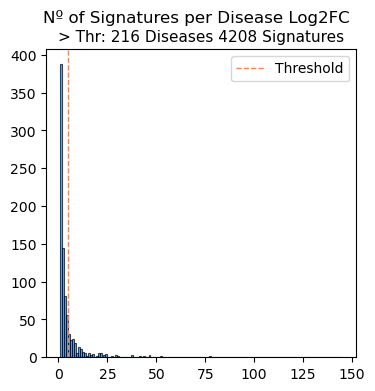

In [29]:
# plot nº of signatures per disease
values = [len(v) for v in disease_2_dsaid_filtered.values()]

# Recalculating based on the bin width of 1
bin_width = 1
min_bin = np.floor(np.min(values))
max_bin = np.ceil(np.max(values))
bins = np.arange(min_bin, max_bin + bin_width, bin_width)


plt.figure(figsize=(4, 4))
plt.hist(
    x=values, bins=bins, alpha=0.7, edgecolor="black", linewidth=0.8, color="#1E90FF"
)
plt.axvline(x=5, color="#FF7F50", linestyle="dashed", linewidth=1, label="Threshold")
title_txt = f"Nº of Signatures per Disease {metric_evaluated}"
title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
plt.suptitle(title_txt)
n_signatures_above_thr = sum(
    [len(v) for v in disease_2_dsaid_filtered.values() if len(v) >= 5]
)
plt.title(
    f"> Thr: {len(most_common_diseases)} Diseases {n_signatures_above_thr} Signatures",
    fontsize=11,
)
plt.legend()
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"mesh.n_signatures_per_disease.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [30]:
# count how many dsaids have data


# count how many dsaids have information
# count nans from the pre-computed matrix

### Compute Similarities

In [31]:
# imports
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
import random

# variables


#  functions
def generate_pairs_2_lists(interest_idxs, rest_idxs, bootstrap=False):
    """Generate pairs of indexes for a given list of indexes
    Arguments:
        - interest_idxs (list): list of indexes
        - rest_idxs (list): list of indexes
    Yields:
        - list: list of pairs of indexes
    """
    for idx_interest in interest_idxs:
        if bootstrap:
            rest_idxs = np.empty(len(interest_idxs) * 100, dtype=int)
            for i in range(100):
                _sample = np.random.choice(
                    rest_idxs, size=len(interest_idxs), replace=True
                )
                rest_idxs[i : (i + 1) * len(interest_idxs)] = _sample
        for idx_other in rest_idxs:
            if idx_interest != idx_other:
                if bootstrap:
                    yield np.array([idx_interest, idx_other], dtype=int)


def generate_pairs_1_list(interest_idxs, unique=True):
    """Generate pairs of indexes for a given list of indexes

    Generators are designed to be memory-efficient by generating
    items one at a time and not keeping them in memory. This means
    they do not have a length or size property like lists or arrays.

    Arguments:
        - interest_idxs (list): list of indexes
    Yields:
        - list: list of pairs of indexes

    """
    if not unique:
        for idx_i, element_i in enumerate(interest_idxs):
            for idx_j, element_j in enumerate(interest_idxs):
                if idx_i != idx_j:
                    yield np.array([element_i, element_j], dtype=int)
    if unique:
        for idx_i, element_i in enumerate(interest_idxs):
            for element_j in interest_idxs[idx_i + 1 :]:
                yield np.array([element_i, element_j], dtype=int)


def get_rest_indexes(interest_idxs, all_indexes, proportion=100):
    """Get rest indexes
    Arguments:
        - interest_idxs (list): list of indexes of interest
        - all_indexes (list): list of all indexes
        - n_random_indexes (int): nº of random indexes
    Returns:
        - random_rest_indexes (list): list of random indexes
    """
    import numpy as np

    # Get subset of indexes for rest
    all_rest_indexes = all_indexes - set(interest_idxs)

    # n_random_indexes
    n_random_indexes = (
        len(interest_idxs) * proportion
        if len(interest_idxs) * proportion < len(all_rest_indexes)
        else len(all_rest_indexes)
    )

    # random indexes withtout replacement - appear once
    random_rest_indexes = np.random.choice(
        list(all_rest_indexes), size=n_random_indexes, replace=False
    )

    return random_rest_indexes


def compute_euclidean_distance(data_matrix_1, data_matrix_2=None):
    """Compute Euclidean Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of Euclidean distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="euclidean")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="euclidean")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_cosine_distance(data_matrix_1, data_matrix_2=None):
    """Compute Cosine Distance
    Arguments:
        - data_matrix_1 (numpy): First matrix of values.
        - data_matrix_2 (numpy, optional): Second matrix of values. If not None, distances are computed between pairs of data_matrix_1 and data_matrix_2.
    Returns:
        - distance_values (numpy.ndarray): Array of cosine distance values.
    """
    if data_matrix_2 is not None:
        # Compute distances between data_matrix_1 and data_matrix_2
        distance_matrix = cdist(data_matrix_1, data_matrix_2, metric="cosine")
    else:
        # Compute pairwise distances within data_matrix_1
        distance_matrix = pdist(data_matrix_1, metric="cosine")
        # Convert to square form to make it consistent with the cdist output
        distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return distance_values


def compute_pearson_correlation(data_matrix_1, data_matrix_2=None):
    """Compute Pearson Correlation
    Arguments:
        - matrix (numpy): matrix of values
    Returns:
        - correlation_values (list): correlation list
    """
    # Compute correlation matrix
    if data_matrix_2 is not None:
        correlation_matrix = np.corrcoef(data_matrix_1, data_matrix_2)
        correlation_matrix = correlation_matrix[
            : data_matrix_1.shape[0], data_matrix_1.shape[0] :
        ]
    else:
        correlation_matrix = np.corrcoef(data_matrix_1)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return correlation_values


def check_old_method_correlation(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]
    # Pearson Correlation
    correlation_matrix = np.corrcoef(matrix_interest)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return np.mean(correlation_values)


def check_old_method_cosine(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # Compute pairwise distances within data_matrix_1
    distance_matrix = pdist(matrix_interest, metric="cosine")
    # Convert to square form to make it consistent with the cdist output
    distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return np.mean(distance_values)


def check_old_method_euclidean(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # Compute pairwise distances within data_matrix_1
    distance_matrix = pdist(matrix_interest, metric="euclidean")
    # Convert to square form to make it consistent with the cdist output
    distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return np.mean(distance_values)


# compute metrics ONCE - after all we have to do is retrieve data
# pearson correlation
matrix_pearson_correlation = np.corrcoef(data_matrix)

# euclidean distance
_matrix_euclidean_distance = pdist(data_matrix, metric="euclidean")
matrix_euclidean_distance = squareform(_matrix_euclidean_distance)
# cosine distance
_matrix_cosine_distance = pdist(data_matrix, metric="cosine")
matrix_cosine_distance = squareform(_matrix_cosine_distance)

In [39]:
# # store value of matrixes w/ %store !
# %store matrix_pearson_correlation matrix_euclidean_distance matrix_cosine_distance metric_evaluated sparsity most_common_diseases disease_2_dsaid_filtered dsaids_matrix data_matrix df_data_info_processed_filtered

Stored 'matrix_pearson_correlation' (ndarray)
Stored 'matrix_euclidean_distance' (ndarray)
Stored 'matrix_cosine_distance' (ndarray)
Stored 'metric_evaluated' (str)
Stored 'sparsity' (str)
Stored 'most_common_diseases' (list)
Stored 'disease_2_dsaid_filtered' (dict)
Stored 'dsaids_matrix' (list)
Stored 'data_matrix' (ndarray)
Stored 'df_data_info_processed_filtered' (DataFrame)


In [ ]:
%run ../scripts/store_variables.py